# BEA Oil & Gas Employment Data Loader

In [6]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL

# Load environment variables
load_dotenv()

# DB connection
engine = create_engine(URL.create(
    "postgresql+psycopg2",
    username=os.environ["DB_USER"],
    password=os.environ["DB_PASSWORD"],
    host=os.environ.get("DB_HOST", "localhost"),
    port=os.environ.get("DB_PORT", "5432"),
    database=os.environ["DB_NAME"],
), echo=False)

COLUMN_NAME = "bea_emp_21"
TARGET_LINE_CODE = 200.0
DATA_PATH = "/home/dadams/Repos/upower_project/data/BEA_income_data/"
FILES = {
    "CO": f"{DATA_PATH}CAEMP25N_CO_2001_2022.csv",
    "TX": f"{DATA_PATH}CAEMP25N_TX_2001_2022.csv"
}

# Ensure column exists
with engine.connect() as conn:
    cols = conn.execute(text("""
        SELECT column_name FROM information_schema.columns 
        WHERE table_name = 'economic_indicators'
    """)).scalars().all()

if COLUMN_NAME not in cols:
    with engine.begin() as conn:
        conn.execute(text(f"ALTER TABLE economic_indicators ADD COLUMN {COLUMN_NAME} NUMERIC"))
    print(f"✅ Column `{COLUMN_NAME}` added.")
else:
    print(f"ℹ️ Column `{COLUMN_NAME}` already exists.")

# Parse and collect data
all_data = []
for state, path in FILES.items():
    df = pd.read_csv(path, encoding="latin1")
    df = df[df["LineCode"] == TARGET_LINE_CODE]
    df = df[~df["GeoFIPS"].str.strip('"').str.endswith("000")]
    years = [str(y) for y in range(2015, 2022) if str(y) in df.columns]

    for _, row in df.iterrows():
        fips = row["GeoFIPS"].strip().strip('"').zfill(5)
        name = row.get("GeoName", "")
        for year in years:
            val = row[year]
            if pd.isna(val) or str(val).strip() in ["", "(D)", "(NA)", "NA"]:
                continue
            try:
                val = float(str(val).replace(",", ""))
                all_data.append({
                    "county_fips": fips,
                    "year": int(year),
                    "employment": val
                })
            except:
                continue

print(f"✅ Parsed {len(all_data)} records.")

# Filter to matching county-year combinations
df_update = pd.DataFrame(all_data)
with engine.connect() as conn:
    keys = set((r["county_fips"].zfill(5), r["year"]) for r in conn.execute(
        text("SELECT county_fips, year FROM economic_indicators")
    ).mappings())

df_update = df_update[df_update.apply(lambda r: (r["county_fips"], r["year"]) in keys, axis=1)]

# Update rows
with engine.begin() as conn:
    for _, r in df_update.iterrows():
        conn.execute(
            text(f"""
                UPDATE economic_indicators
                SET {COLUMN_NAME} = :val
                WHERE county_fips = :fips AND year = :year
            """),
            {"val": r["employment"], "fips": r["county_fips"], "year": r["year"]}
        )

print(f"✅ Updated {len(df_update)} rows.")


ℹ️ Column `bea_emp_21` already exists.
✅ Parsed 1710 records.
✅ Updated 1710 rows.


In [4]:
# Check first few DB keys
print("🔍 First few DB keys:")
with engine.connect() as conn:
    rows = conn.execute(text("SELECT county_fips, year FROM economic_indicators LIMIT 5"))
    for fips, year in rows:
        print(f"{fips!r}, {year}")


# Check first few from the extracted DataFrame
print("\n🔍 First few extracted keys:")
print(df_update[['county_fips', 'year']].drop_duplicates().head())


🔍 First few DB keys:
'08003', 2015
'08005', 2015
'08007', 2015
'08009', 2015
'08011', 2015

🔍 First few extracted keys:
Empty DataFrame
Columns: [county_fips, year]
Index: []


In [5]:
print(f"🔎 Sample from all_data:")
print(all_data[:5])


🔎 Sample from all_data:
[{'county_fips': ' "08001', 'county_name': 'Adams, CO*', 'year': 2015, 'employment': 1474.0}, {'county_fips': ' "08001', 'county_name': 'Adams, CO*', 'year': 2016, 'employment': 1615.0}, {'county_fips': ' "08001', 'county_name': 'Adams, CO*', 'year': 2017, 'employment': 1422.0}, {'county_fips': ' "08001', 'county_name': 'Adams, CO*', 'year': 2018, 'employment': 1203.0}, {'county_fips': ' "08001', 'county_name': 'Adams, CO*', 'year': 2019, 'employment': 1806.0}]


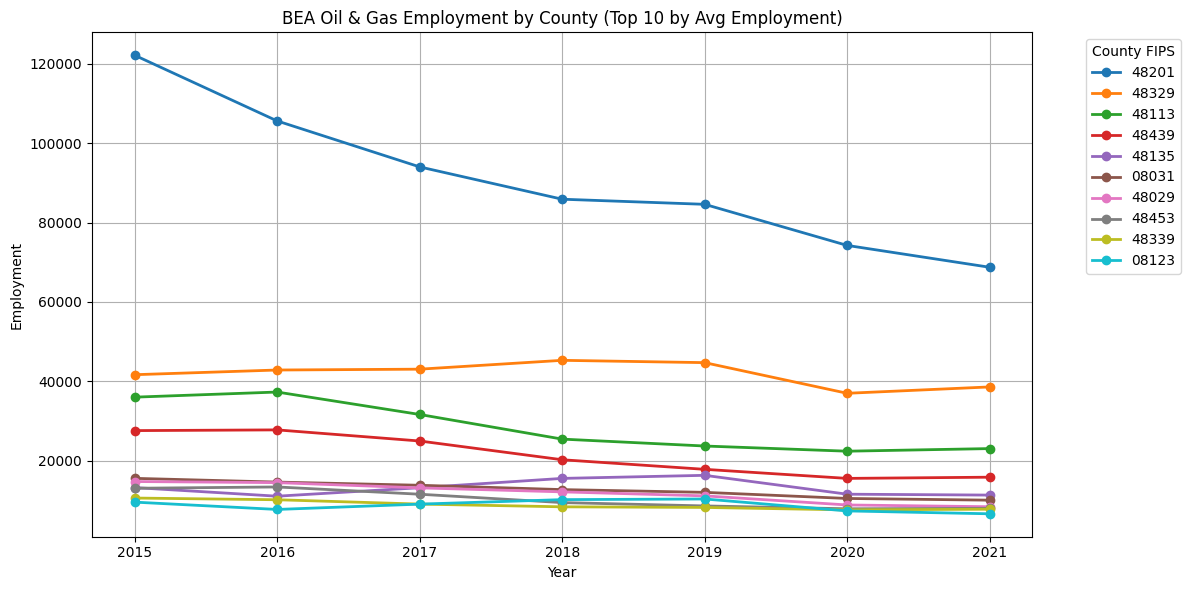

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert all_data to DataFrame
df_plot = pd.DataFrame(all_data)

# Ensure FIPS are zero-padded (5 characters)
df_plot["county_fips"] = df_plot["county_fips"].str.zfill(5)

# Aggregate (mean if there are duplicates — optional)
df_grouped = df_plot.groupby(["year", "county_fips"])["employment"].mean().reset_index()

# Pivot for plotting
pivot_df = df_grouped.pivot(index="year", columns="county_fips", values="employment")

# Plot (top 10 counties by average employment over time)
top_counties = pivot_df.mean().sort_values(ascending=False).head(10).index
pivot_df[top_counties].plot(figsize=(12, 6), marker='o', linewidth=2)

plt.title("BEA Oil & Gas Employment by County (Top 10 by Avg Employment)")
plt.xlabel("Year")
plt.ylabel("Employment")
plt.grid(True)
plt.legend(title="County FIPS", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


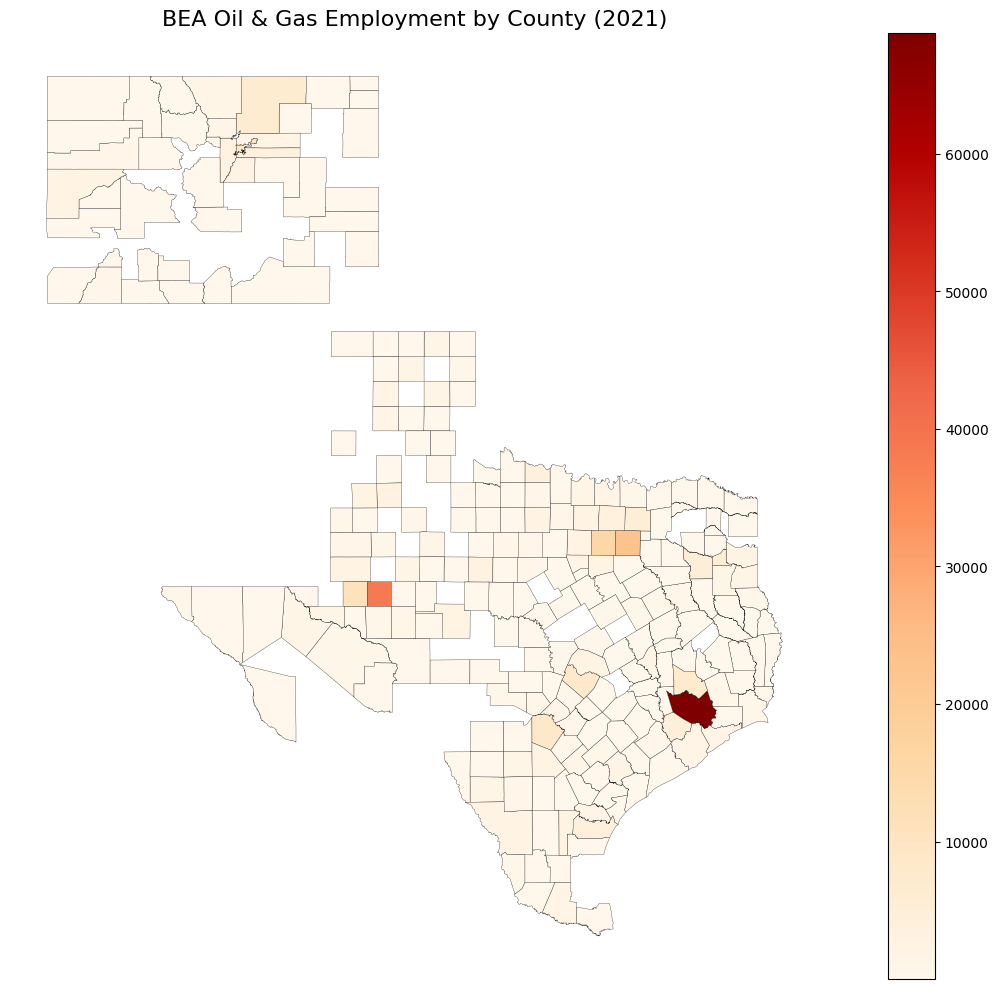

In [12]:
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

# Load DB credentials
load_dotenv()
engine = create_engine(URL.create(
    "postgresql+psycopg2",
    username=os.environ["DB_USER"],
    password=os.environ["DB_PASSWORD"],
    host=os.environ.get("DB_HOST", "localhost"),
    port=os.environ.get("DB_PORT", "5432"),
    database=os.environ["DB_NAME"],
))

# Set year to visualize
TARGET_YEAR = 2021

# Query joined data
query = f"""
    SELECT 
        c.county_fips,
        c.name,
        c.state,
        c.geom,
        e.bea_emp_21
    FROM counties c
    JOIN economic_indicators e
      ON c.county_fips = e.county_fips
     AND e.year = {TARGET_YEAR}
    WHERE e.bea_emp_21 IS NOT NULL
"""

# Load into GeoDataFrame
gdf = gpd.read_postgis(query, engine, geom_col="geom")

# Plot
fig, ax = plt.subplots(figsize=(14, 10))
gdf.plot(column="bea_emp_21", cmap="OrRd", legend=True,
         edgecolor="black", linewidth=0.2, ax=ax)

ax.set_title(f"BEA Oil & Gas Employment by County ({TARGET_YEAR})", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()
